# 1. Service Registration 

### Docker 

In [4]:
import docker
dockerClient = docker.from_env()
dockerClient.images.pull('mysql:8.0.16')
c = docker.APIClient(base_url='unix://var/run/docker.sock')

In [5]:
import re 

# get container info
def get_info(container):
    service_name = c.inspect_container(container.id)['Name'] #service name
    IP_address = c.inspect_container(container.id)['NetworkSettings']['Networks']['bridge']['IPAddress']
    exposed_port = list(c.inspect_container(container.id)['Config']['ExposedPorts'].keys())[0]
    port = re.findall('\d+', exposed_port)[0]
    return(service_name, IP_address, port)

### MySQL database 

- Database: demo
- Table: reg_container
- Columns: 
    - last_check : last resgistered running time 
    - service    : service name      
    - ip_address : IP Address        
    - port_num      : exposed port      

In [26]:
# connect to database
import mysql.connector
db = mysql.connector.connect(host='localhost',user='root',passwd='password',database='demo') 
cursor = db.cursor()

In [ ]:
# create unique index
create_index = "CREATE UNIQUE INDEX index ON reg_container(service, ip_address, port_num)"
cursor.execute(create_index)

In [7]:
from mysql.connector import Error
from mysql.connector import errorcode

def update_db():
    try:
        update_db_exec()
    except Exception as e:
        raise

# update database 
# avoid duplicates
def update_db_exec():
    for container in dockerClient.containers.list():
        count_sql = "SELECT count(*) FROM reg_container WHERE service = %s AND ip_address = %s AND port_num = %s"
        val = get_info(container)
        cursor.execute(count_sql, val)
        count_entry = cursor.fetchone()[0]
    
        if count_entry == 0:
            try:
                insert_sql = "INSERT INTO reg_container (last_check, service, ip_address, port_num) VALUES (NOW(), %s, %s, %s)"
                cursor.execute(insert_sql, val)
                db.commit()
                print("Insert record successfully")
            except Exception as e:
                raise
        else:
            try:
                update_sql = "UPDATE reg_container SET last_check = NOW() WHERE service = %s AND ip_address = %s AND port_num = %s"
                cursor.execute(update_sql, val)
                print("Update record successfully")
                db.commit()
            except Exception as e:
                raise

## 2. Service Discovery 

Check running containers within specific time interval on database

In [13]:
time_interval = 3 # hour

# get ip address and port of active containers
def check_service(service):
    info = []
    getservice_sql = "SELECT ip_address, port_num FROM reg_container WHERE last_check > NOW() - INTERVAL %s HOUR AND service = %s"
    cursor.execute(getservice_sql,(time_interval,service,))
    sql_result = cursor.fetchall() 
    
    # reformat
    for ip, port in sql_result:
        info.append("{:s}:{:s}".format(ip,port)) 
    return info

check_service('/ans_generation')


['120.118.148.194:9000']

### Utility functions

Background scheduler

In [ ]:
import queue
from apscheduler.schedulers.background import BackgroundScheduler
from apscheduler.events import EVENT_JOB_EXECUTED, EVENT_JOB_ERROR, JobExecutionEvent

update_interval = 5 # time interval for database update
check_interval = 10 # time interval for service discovert

# background scheduler 
sched = BackgroundScheduler()
sched.add_job(check_service, 'interval', seconds=check_interval, id='check')
sched.add_job(update_db, 'interval', seconds=update_interval, id='update')
sched.start()

In [ ]:
# force shutdown scheduler
sched.shutdown(wait=False)

Insert and delete entry

In [ ]:
insert_val = ['/retrieval','168.212.226.204','7000']

def insert_entry():
    insert_sql = "INSERT INTO reg_container (last_check,service,ip_address,port_num) VALUES (NOW(),%s,%s,%s)"
    cursor.execute(insert_sql, insert_val)
    db.commit()
    print(cursor.rowcount, 'new record(s)')
    
insert_entry()

In [569]:
delete_val = ('10.128.148.193',) 

def delete_entry():
    delete_sql = "DELETE FROM reg_container WHERE ip_address = %s AND service = '/intent_detection'"
    cursor.execute(delete_sql, delete_val)
    db.commit()
    print(cursor.rowcount, 'record(s) deleted')
    
delete_entry()

0 record(s) deleted


## 3. Resources Allocation 

Normalization:
- inverse execution time
- normalize inversed time to base 500

Task assignment:
- random numbers generated follow uniform distribution

In [14]:
import numpy as np

scale_min = 0      # min value on new scale 
scale_max = 500    # max value on new scale

# normalize total execution time
# rescale according to processing speed of container
def normalize(service_name):
    active = check_service(service_name)
    df = temp_df[['ip_port','exec_time']].loc[(temp_df.ip_port.isin(active))&(temp_df.service==service_name)]
    d = dict(zip(df.ip_port, df.exec_time))
    for val in d:
        d[val] = np.reciprocal(float(d[val])) # processing speed
        
    rescale = float(scale_max/sum(d.values())) # scale factor
    for val in d:
        d[val] = d[val] * rescale
    return d

# assign task based on processing power of container
def assign_request(service):
    normalized = normalize(service)
    assign_value = np.random.uniform(scale_min,scale_max,1) # uniform distribution
    for key, value in sorted(normalized.items()): 
        assign_value -= value
        if assign_value < 0:
            return key

## Demo 1, 2: Periodic Update 

In [84]:
import queue
from apscheduler.schedulers.background import BackgroundScheduler
from apscheduler.events import EVENT_JOB_EXECUTED, EVENT_JOB_ERROR, JobExecutionEvent

# store ip_address and port info for all services in queue
check_service_result = queue.Queue()

# get return value of scheduled task
def listener(event):
    if event.retval is not None:
        check_service_result.put(event.retval)
        return check_service_result
    else:
        pass 

# scheduling task for periodic update
s = BackgroundScheduler()
s.add_job(check_service, 'interval', seconds=5, id='check')
s.add_job(update_db, 'interval', seconds=10, id='update')
s.add_listener(listener, EVENT_JOB_EXECUTED)
s.start()

Update record successfully
Update record successfully
Update record successfully


In [85]:
# force shutdown
s.shutdown(wait=False)

In [ ]:
while check_service_result.empty() is not True:
    print(check_service_result.get(), '\n')

## Demo 3: Assign Task

### Pre-assignment
Manually assign execution time of containers for testing 
- assign execution time with integer from 1-10

In [27]:
import pandas as pd
import random

# get container info from existing database
cursor.execute("SELECT service,ip_address,port_num FROM reg_container")
temp_df = pd.DataFrame(cursor.fetchall())
temp_df.columns = cursor.column_names

# reformat ip_address, port_num columns 
# assign individual execution time
temp_df['ip_port'] = ["{:s}:{:s}".format(temp_df['ip_address'].iloc[i],temp_df['port_num'].iloc[i]) for i in range(len(temp_df))]
temp_df['exec_time'] = [random.randint(1,10) for i in range(len(temp_df))]
temp_df.drop(columns=['ip_address','port_num'], inplace=True)


In [28]:
temp_df[temp_df.service == '/ans_generation'].head()

,service,ip_port,exec_time
0,/ans_generation,172.17.0.3:3306,1
6,/ans_generation,172.16.0.0:3360,5
7,/ans_generation,172.18.0.3:3360,4
8,/ans_generation,172.18.0.3:3370,7
14,/ans_generation,172.16.254.1:6000,10


## 1. Check Distribution for Task Scheduling
- total running time: ensure resources are allocated equally
- linear relationship: ensure resources are allocated according to individual container's processing power
- exponential pattern: ensure resources are allocated according to individual container's executime time

### Case 1: Single active container
Assign 1000 requests to 1 container (by changing time_interval for check_service function)

In [39]:
# check task count for single container
# assume only 1 container is active

def assign_to_one(service,num):
    assignment = []
    for i in range(num):
        assignment.append(assign_request(service))
    
    active = check_service(service)
    df = temp_df[['ip_port','exec_time']][(temp_df.ip_port.isin(active))&(temp_df.service==service)]
    df['task_count'] = [int(assignment.count(i)) for i in df['ip_port']]

    plt.figure(figsize=(4,3))
    plt.title(service)
    plt.bar(df['ip_port'], df['task_count'], color='orange')
    plt.show()
    
    return df

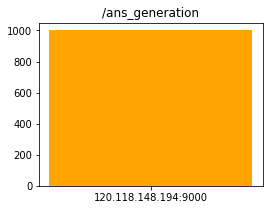

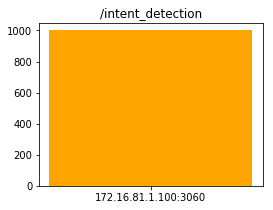

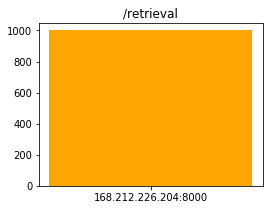

In [40]:
# assign all task to single active container
# assum that only one container is active
ans_gen = assign_to_one('/ans_generation',1000)
intent_det = assign_to_one('/intent_detection',1000)
retrieval = assign_to_one('/retrieval',1000)

### Case 2: Small number of requests, multiple containers
Assign 5 requests for each service (by changing time_interval for check_service function)

In [467]:
task_num = 5
services = ['/ans_generation','/intent_detection','/retrieval']

# assign tasks to all services
for service in services:
    print(service)
    for i in range(task_num):
        print(assign_request(service))
    print(' ')

/ans_generation
172.16.81.100:6000
168.212.226.204:8080
172.17.0.3:3306
172.17.0.3:3306
192.0.2.1:3060
 
/intent_detection
192.168.0.5:8080
172.16.81.100:7700
192.168.0.5:8080
192.0.2.1:3060
192.0.2.1:3060
 
/retrieval
192.168.0.5:3309
10.118.148.190:7000
10.128.148.193:3300
10.118.148.190:7000
10.118.148.190:7000
 


### Case 3: Large number of requests, multiple containers
Check total running time for each container (by changing time_interval for check_service function)

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# assign multiple tasks
# check distribution of tasks assigned to respective container
def assign_multiple(service,num):
    assignment = []
    for i in range(num):
        assignment.append(assign_request(service))
    
    active = check_service(service)
    df = temp_df[['ip_port','exec_time']][(temp_df.ip_port.isin(active))&(temp_df.service==service)]
    df['task_count'] = [int(assignment.count(i)) for i in df['ip_port']]
    df['total_time'] = [int(assignment.count(i)*df['exec_time'][df.ip_port==i].values) for i in df['ip_port']]

    plt.figure(figsize=(4,3))
    plt.title(service)
    plt.bar(df['ip_port'], df['total_time'])
    plt.show()
    
    return df

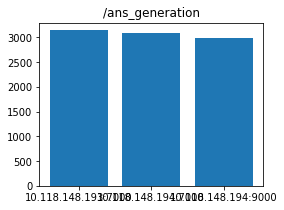

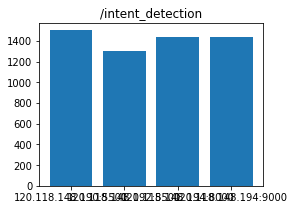

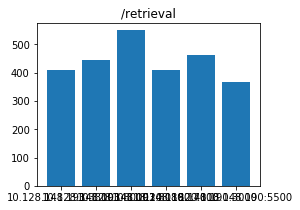

In [504]:
# assign 1000 tasks for small number of containers
# by changing time_interval for check_service function
ans_gen = assign_multiple('/ans_generation',1000)
intent_det = assign_multiple('/intent_detection',1000)
retrieval = assign_multiple('/retrieval',1000)

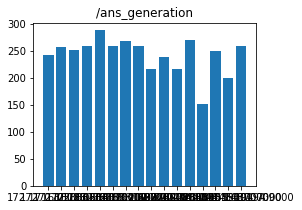

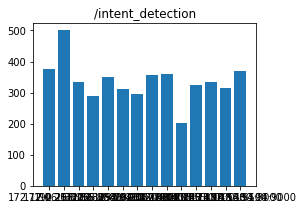

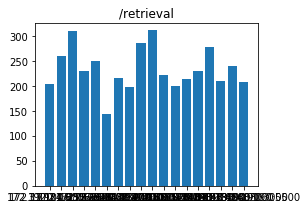

In [512]:
# assign tasks to all existing containers
# by changing time_interval for check_service function
ans_gen1 = assign_multiple('/ans_generation',1000)
intent_det1 = assign_multiple('/intent_detection',1000)
retrieval1 = assign_multiple('/retrieval',1000)

## 2. Check for linear relationship (w.r.t normalised processing speed)


### Case 1: Overview distribution

In [478]:
# plot tasks assigned w.r.t to processing speed
# should show linear relationship
# processing speed is rescaled for aid of visualization
def linear_check(df,title):
    ind = np.arange(len(df))
    width = 0.3
    multiple = df['exec_time'].apply(lambda x: 500*np.reciprocal(float(x)))
    
    fig, ax = plt.subplots()
    bar1 = ax.bar(ind,multiple,width)
    bar2 = ax.bar(ind+width,df['task_count'],width)
    ax.legend((bar1[0],bar2[0]),('Normalized processing speed','Task count'))
    ax.set_title(title)
    plt.show()

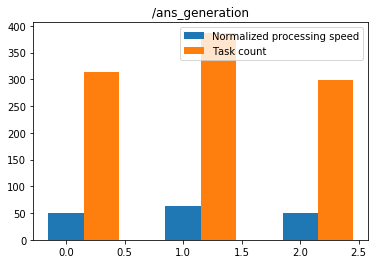

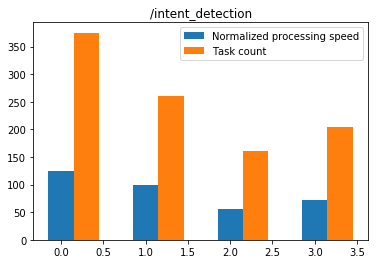

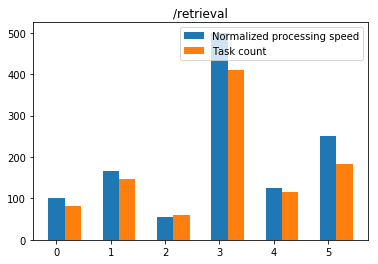

In [505]:
# check for linear relationship
linear_check(ans_gen, services[0])
linear_check(intent_det, services[1])
linear_check(retrieval, services[2])

### Case 2: Detailed distribution

In [576]:
# check task count ratio of 3 active containers in 'ans_generation'
active =['172.17.0.3:3306','172.16.0.0:3360','172.18.0.3:3370']

def normalize3(service_name):
    df = temp_df[['ip_port','exec_time']].loc[(temp_df.ip_port.isin(active))&(temp_df.service==service_name)]
    d = dict(zip(df.ip_port, df.exec_time))
    for val in d:
        d[val] = np.reciprocal(float(d[val])) # processing speed
        
    rescale = float(scale_max/sum(d.values())) # scale factor
    for val in d:
        d[val] = d[val] * rescale
    return d


def assign3(service):
    normalized = test_normalize(service)
    assign_value = np.random.uniform(scale_min,scale_max,1) # uniform distribution
    for key, value in sorted(normalized.items()): 
        assign_value -= value
        if assign_value < 0:
            return key
        

def test3(service,num):
    assignment = []
    for i in range(num):
        assignment.append(test_assign(service))
    
    df = temp_df[['ip_port','exec_time']][(temp_df.ip_port.isin(active))&(temp_df.service==service)]
    df['task_count'] = [int(assignment.count(i)) for i in df['ip_port']]
    df['total_time'] = [int(assignment.count(i)*df['exec_time'][df.ip_port==i].values) for i in df['ip_port']]

    plt.figure(figsize=(4,3))
    plt.title(service)
    plt.bar(df['ip_port'], df['total_time'])
    plt.show()
    
    return df

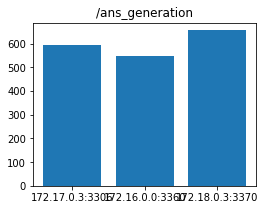

,ip_port,exec_time,task_count,total_time
0,172.17.0.3:3306,1,595,595
6,172.16.0.0:3360,2,274,548
8,172.18.0.3:3370,5,131,655


In [577]:
# container task_count should have linear relationship with its exec_time
test3(services[0], 1000)

## 3. Check for exponential pattern (w.r.t execution time)

In [566]:
from scipy.optimize import curve_fit

# exponential decay function
def func(x, a, k, b):
    return a * np.exp(-k*x) + b

# plot tasks assigned w.r.t. execution time 
# should fit exponential decay graph
def exponential_check(df,title):
    x = df['exec_time']
    y = df['task_count']
    trialX = np.linspace(x.iloc[0], x.iloc[-1], 100)
    coef, pcov = curve_fit(func, x, y)
    print(coef)
    yEXP = func(trialX,*coef)

    plt.figure()
    plt.scatter(x, y, label='Data', marker='o')
    plt.plot(trialX, yEXP, 'r-',ls='--', label="Exp Fit")
    plt.title(title)
    plt.legend()
    plt.show()

[421.5513561    0.69316008  26.53110572]


/Users/zhiyun.yap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


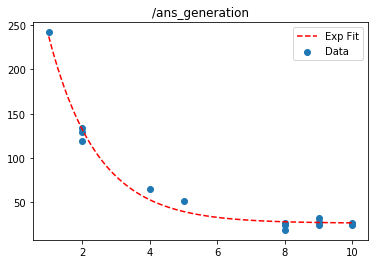

In [567]:
# check for exponential graph
exponential_check(ans_gen1, services[0])